# Task description:
- Experiment with the number of hidden neurons and the learning rate. Which changes produce a linear output behaviour and which changes lead to strong "overfitting"?

### Answer: <br>
The number of neurons in a neural network determines its capacity to learn and represent complex patterns in the data. Increasing the number of neurons generally increases the model's ability to capture intricate relationships and improve its performance. However, having too many neurons can lead to overfitting, where the model becomes too specialized to the training data and performs poorly on new, unseen data. <br>
<br>
When you increase the learning rate of a neural network, it can lead to faster convergence during training. But if it is too high, it may cause the training to become unstable, becoming too linear. On the other hand, decreasing the learning rate slows down the training process but can improve the model's ability to converge to a better solution and potentially avoid overshooting or divergence. When the learning rate is too small, the model's updates to the parameters are tiny, causing the training process to progress very slowly. This can result in the model not being able to effectively explore the parameter space and converge to an optimal solution. As a result, the model may fail to capture the underlying patterns in the data and instead become overly complex, fitting the training data too closely and performing poorly on unseen data.

# Implementation:

In [13]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict

Load the data

In [14]:
# set the printing options for Tensor objects in PyTorch to display only the first and last 
# two elements and limit the line width to 75 characters for improved readability.
torch.set_printoptions(edgeitems=2, linewidth=75) 

# load data
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# make them a two dimensional tensor by adding a dimension
# size: len(t_u) -> size: [len(t_u), 1]
t_c = torch.tensor(t_c).unsqueeze(1) 
t_u = torch.tensor(t_u).unsqueeze(1) 

print("shape of t_u:", t_u.shape)

shape of t_u: torch.Size([11, 1])


Split the dataset in training and validation data

In [15]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples) # 20% der testdaten sind Validierungsdaten

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

print("train_indices:", train_indices)
print("val_indices:", val_indices)

train_indices: tensor([10,  1,  3,  7,  0,  6,  9,  2,  8])
val_indices: tensor([4, 5])


In [16]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

Definition of the training loop

In [17]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val, printing=True):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if printing is True: # only print if printing is set to True
            if epoch == 1 or epoch % 1000 == 0:
                print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                    f" Validation loss {loss_val.item():.4f}")


Definition of the sequential model

In [18]:
def train_seq_model(num_neurons, learningrate, printing=False):
    seq_model = nn.Sequential(OrderedDict([
        ('hidden_linear', nn.Linear(1, num_neurons)),
        ('hidden_activation', nn.Tanh()),
        ('output_linear', nn.Linear(num_neurons, 1))
    ]))

    if printing is True:
        print("Model:",seq_model)

        for name, param in seq_model.named_parameters():
            print(name, param.shape)

    optimizer = optim.SGD(seq_model.parameters(), lr=learningrate)

    training_loop(
        n_epochs=5000,
        optimizer=optimizer,
        model=seq_model,
        loss_fn=nn.MSELoss(),
        t_u_train=t_un_train,
        t_u_val=t_un_val,
        t_c_train=t_c_train,
        t_c_val=t_c_val,
        printing=printing)

    return seq_model

In [19]:
seq_model = train_seq_model(num_neurons=8, learningrate=1e-3, printing=True)

Model: Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)
hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])
Epoch 1, Training loss 210.0498, Validation loss 94.2353
Epoch 1000, Training loss 4.3470, Validation loss 2.7678
Epoch 2000, Training loss 3.8718, Validation loss 0.5981
Epoch 3000, Training loss 2.5894, Validation loss 0.4970
Epoch 4000, Training loss 2.2272, Validation loss 0.5463
Epoch 5000, Training loss 2.0485, Validation loss 0.8180


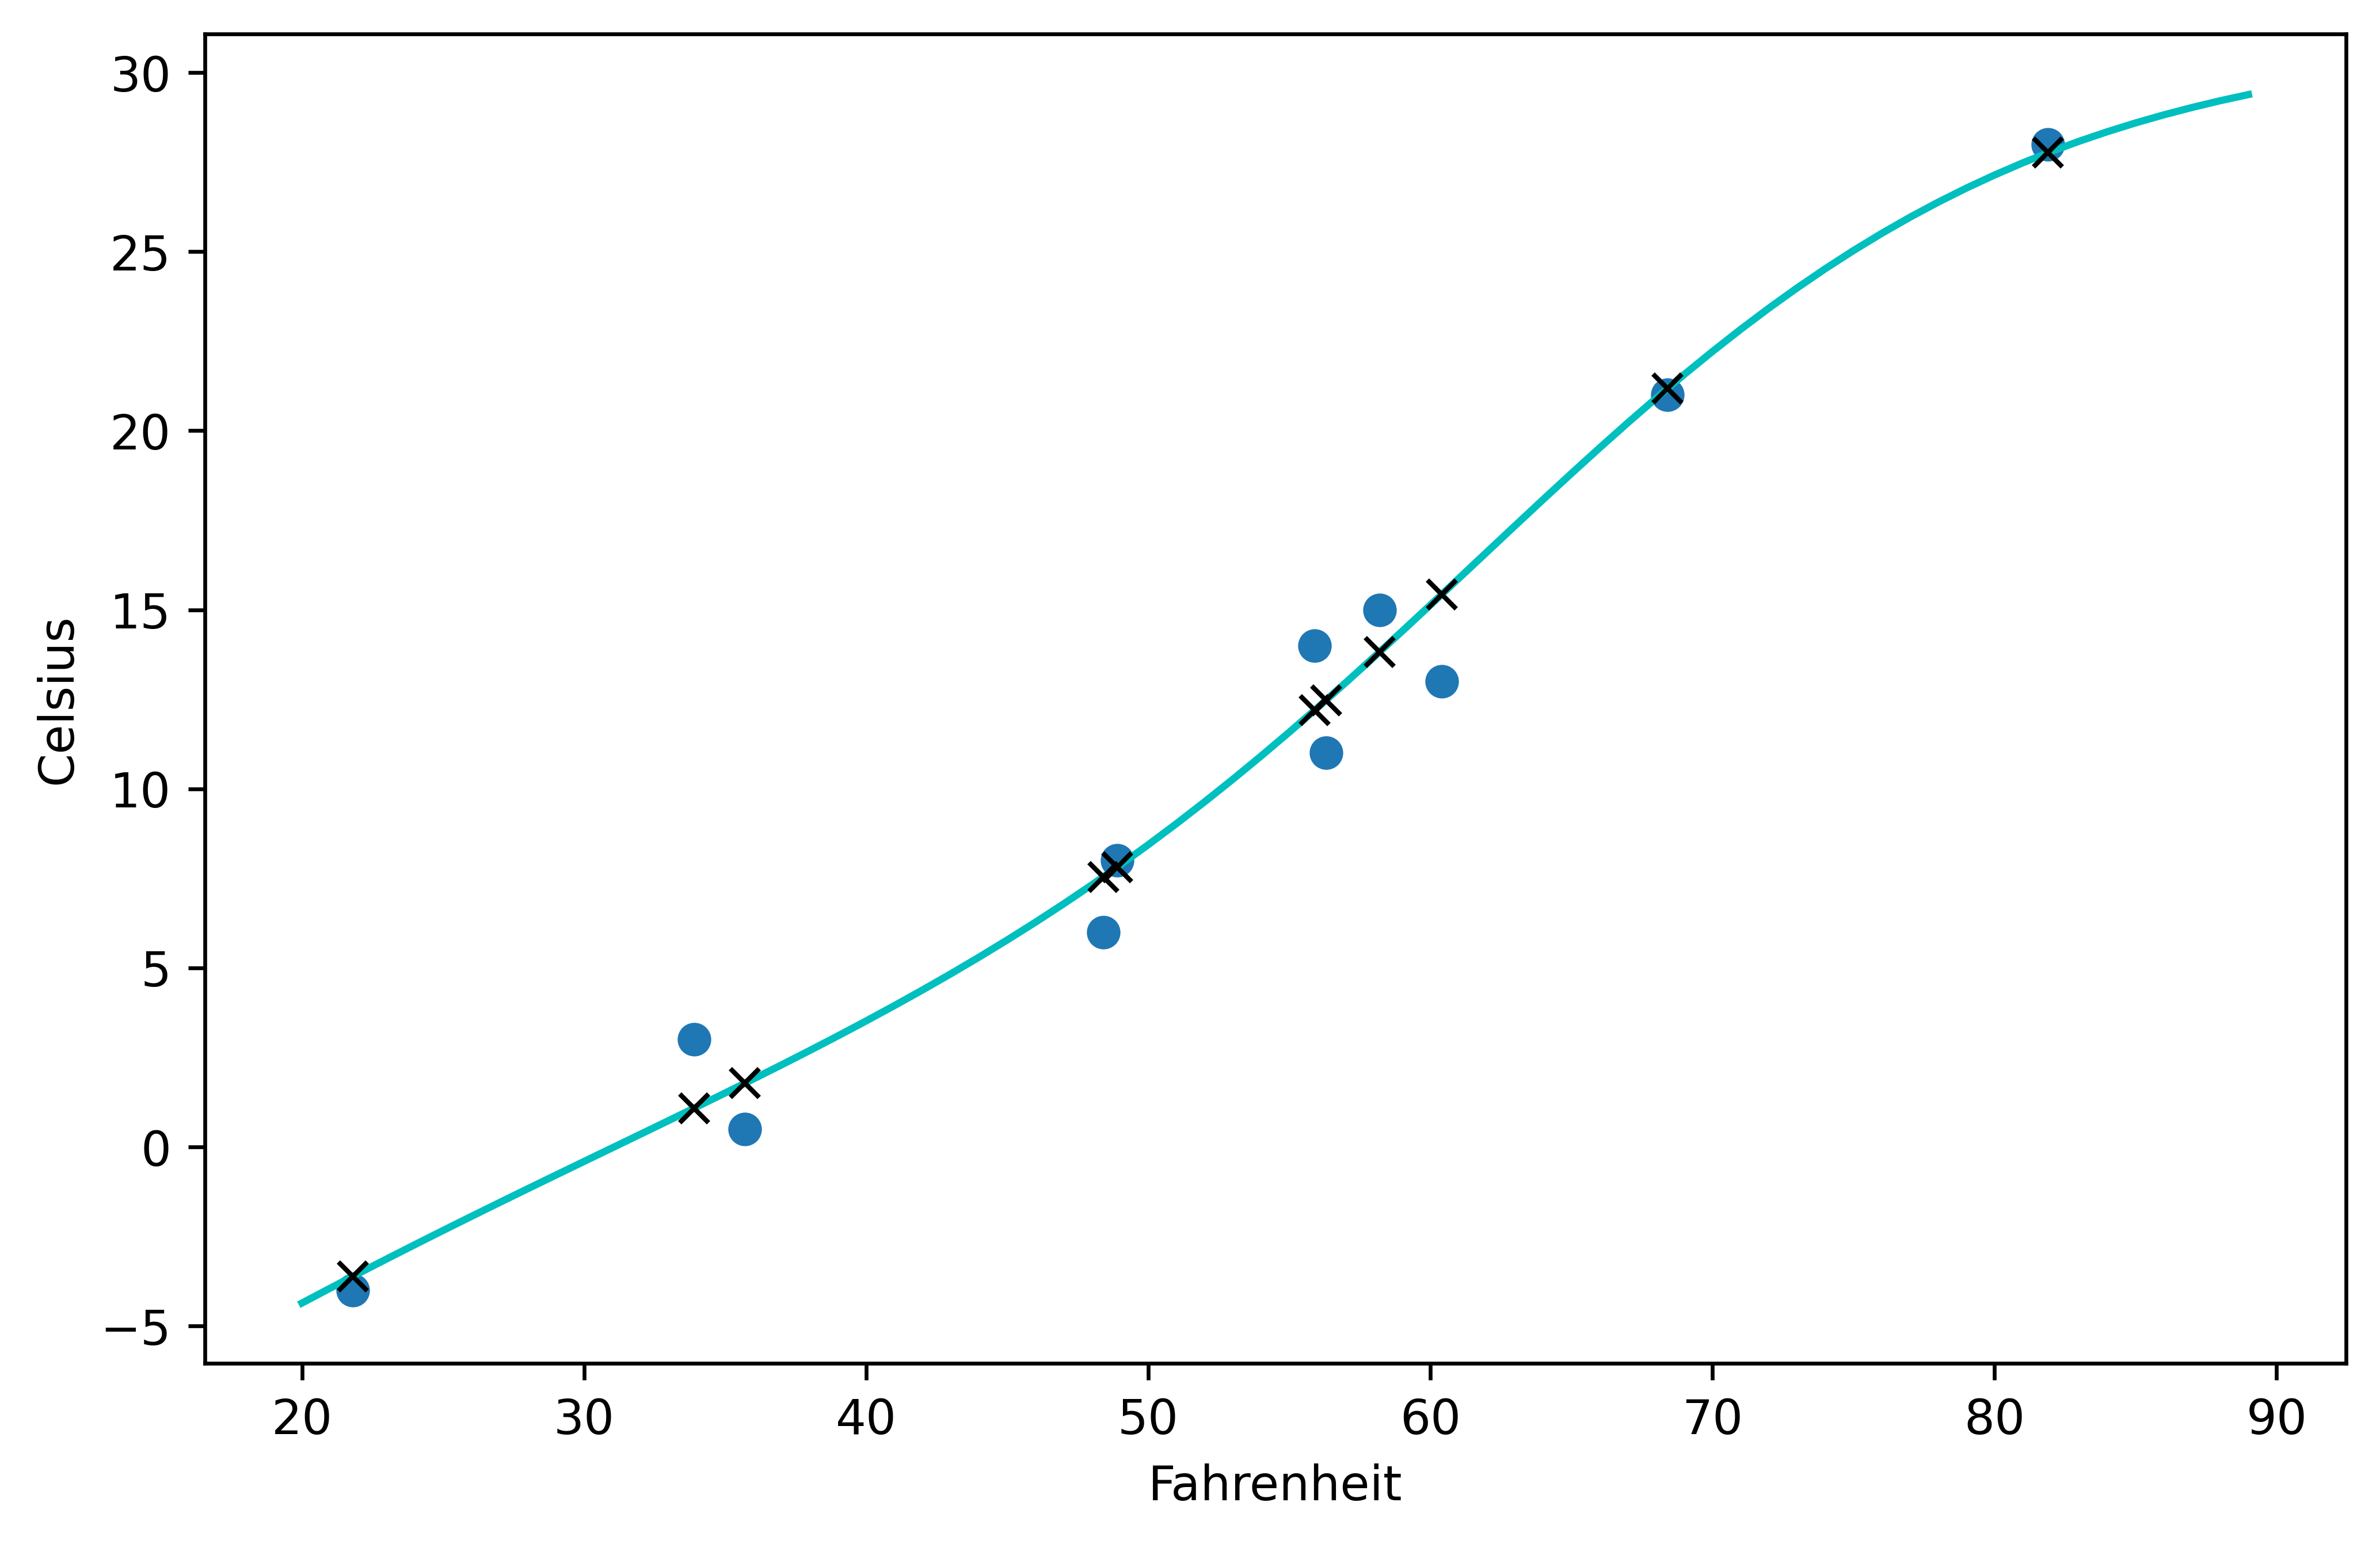

In [20]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600, figsize=(8,5))
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

Experiment with different amounts of neurons

In [21]:
seq_model_1 = train_seq_model(num_neurons=1, learningrate=1e-3, printing=False)

# and again for a different number of neurons
seq_model_2 = train_seq_model(num_neurons=1500, learningrate=1e-3, printing=False)

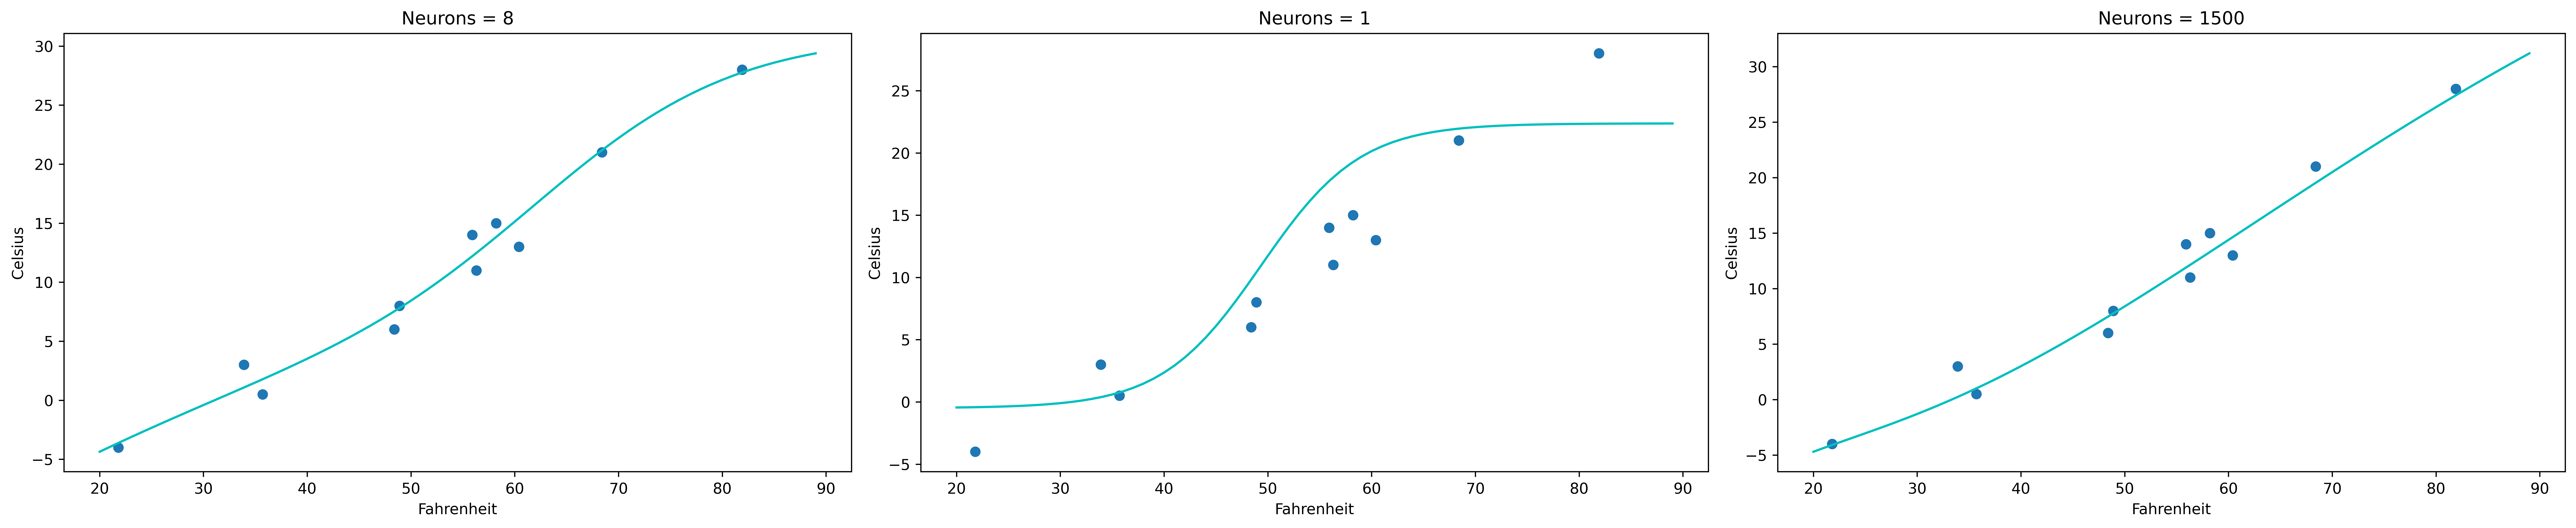

In [22]:
seq_models_neurons = [seq_model, seq_model_1, seq_model_2]
headers = ["Neurons = 8", "Neurons = 1", "Neurons = 1500"]
fig, axes = plt.subplots(1, 3, dpi=600, figsize=(24,5))
for ax, i in zip(axes, range(3)):
    ax.set_title(headers[i])
    ax.set_xlabel("Fahrenheit")
    ax.set_ylabel("Celsius")
    ax.plot(t_u.numpy(), t_c.numpy(), 'o')
    ax.plot(t_range.numpy(), seq_models_neurons[i](0.1 * t_range).detach().numpy(), 'c-')

plt.tight_layout()
plt.show()

Experiment with different learning rates

In [27]:
seq_model_3 = train_seq_model(num_neurons=8, learningrate=1e-2, printing=False)
seq_model_4 = train_seq_model(num_neurons=8, learningrate=1e-4, printing=False)

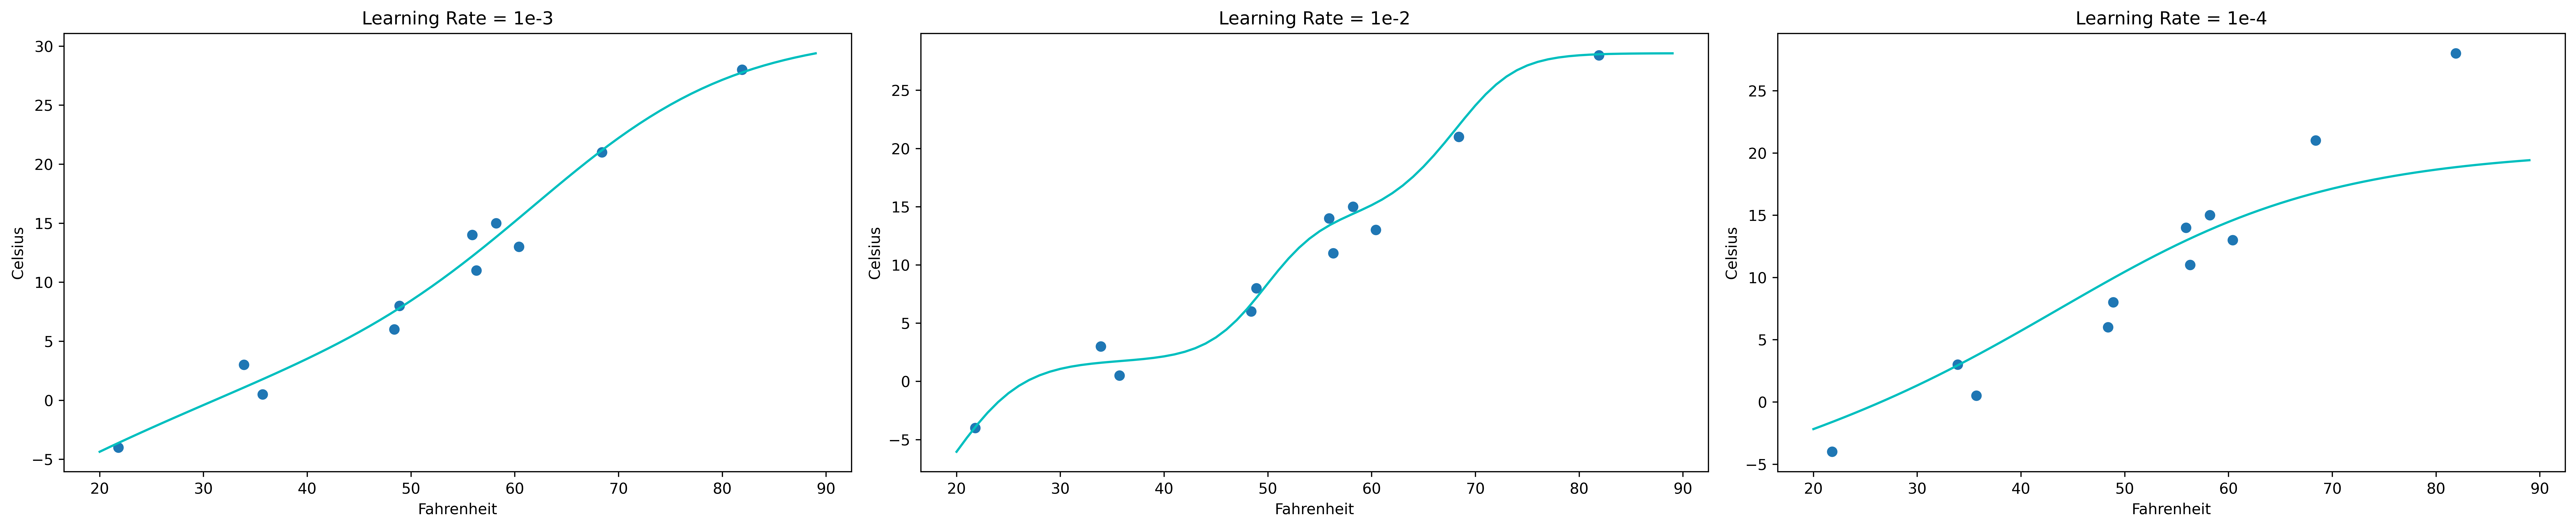

In [29]:
seq_models_lr = [seq_model, seq_model_3, seq_model_4]
headers = ["Learning Rate = 1e-3", "Learning Rate = 1e-2", "Learning Rate = 1e-4"]
fig, axes = plt.subplots(1, 3, dpi=600, figsize=(24,5))
for ax, i in zip(axes, range(3)):
    ax.set_title(headers[i])
    ax.set_xlabel("Fahrenheit")
    ax.set_ylabel("Celsius")
    ax.plot(t_u.numpy(), t_c.numpy(), 'o')
    ax.plot(t_range.numpy(), seq_models_lr[i](0.1 * t_range).detach().numpy(), 'c-')

plt.tight_layout()
plt.show()